In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd


# read the csv
data = pd.read_csv("/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/data_NVDA.csv")
data.head()

,date,open,high,low,close,volume
0,2013-02-08,12.370,12.4699,12.29,12.37,7677336
1,2013-02-11,12.470,12.6350,12.35,12.51,10207599
2,2013-02-12,12.395,12.5650,12.38,12.43,6945065
3,2013-02-13,12.440,12.6650,12.33,12.37,21322573
4,2013-02-14,12.200,12.7400,12.05,12.73,22049335


### Select a company

In [3]:
# drop nulls
data.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [4]:
# select only required columns
UNWANTED_COLS = ["volume"]

# filter columns
df = data[[col for col in list(data.columns) if col not in UNWANTED_COLS]]
df.head()

,date,open,high,low,close
0,2013-02-08,12.370,12.4699,12.29,12.37
1,2013-02-11,12.470,12.6350,12.35,12.51
2,2013-02-12,12.395,12.5650,12.38,12.43
3,2013-02-13,12.440,12.6650,12.33,12.37
4,2013-02-14,12.200,12.7400,12.05,12.73


In [5]:
# conver the data to pandas date time
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop = True, inplace = True)
df.head()

<ipython-input-5-76cabfe32200>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


,open,high,low,close
date,,,,
2013-02-08,12.370,12.4699,12.29,12.37
2013-02-11,12.470,12.6350,12.35,12.51
2013-02-12,12.395,12.5650,12.38,12.43
2013-02-13,12.440,12.6650,12.33,12.37
2013-02-14,12.200,12.7400,12.05,12.73


### Time series plot

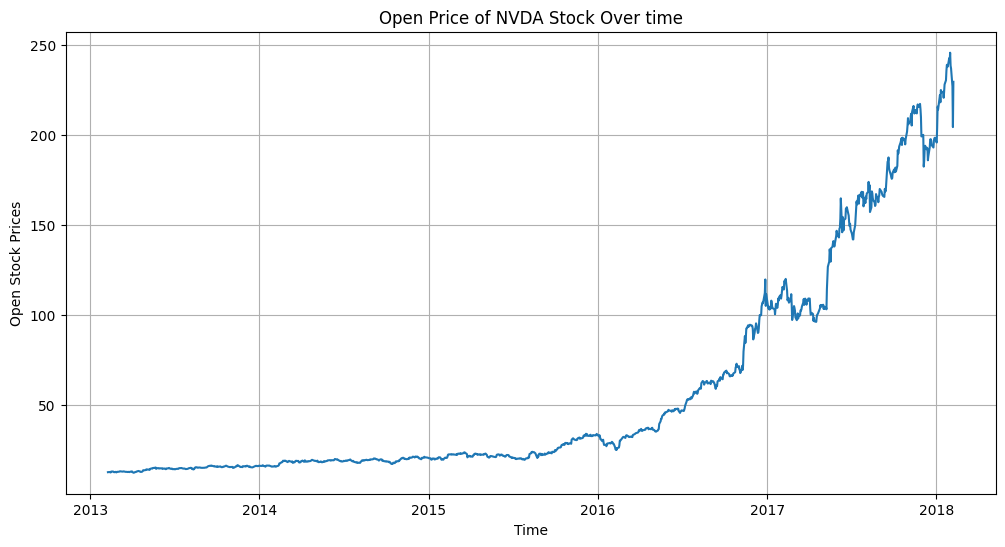

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
COMPANY = "NVDA"
plt.figure(figsize = (12,6))
plt.plot(df["open"])
plt.xlabel("Time")
plt.ylabel("Open Stock Prices")
plt.title("Open Price of {} Stock Over time".format(COMPANY))
plt.grid(True)
plt.show()

### Preprocessing Using MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

MODEL_SAVE_PATH = "/content/drive/Shareddrives/1:1_Krishna_Vijay/Results/Models/"

COLUMNS = list(df.columns)
print("Columns", COLUMNS)

# fit the model
scaler = MinMaxScaler().fit(df[COLUMNS])
# save the model
with open(os.path.join(MODEL_SAVE_PATH, f"{COMPANY}scalermodel_GRU"), "wb") as tesla_model:
    pickle.dump(scaler, tesla_model)
    print("Model Saved")

# fot on data
df[COLUMNS] = scaler.transform(df[COLUMNS])

Columns ['open', 'high', 'low', 'close']
Model Saved


<ipython-input-9-16689d992bb8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[COLUMNS] = scaler.transform(df[COLUMNS])


### Splitting the data

In [ ]:
# define the plsit ratio
SPLIT_RATIO = 0.2

# train length
train_length = int(len(df) * (1 - SPLIT_RATIO))
print("train length", train_length)

train_data = df[:train_length]
test_data = df[train_length:]
print("train shape", train_data.shape)
print("test shape", test_data.shape)

train length 1007
train shape (1007, 4)
test shape (252, 4)


In [ ]:
import numpy as np

def prepare_seq(data,seq_len):    #eg seq=len = 50
    sequences,labels = [],[]
    #len of data is 1353 then 1353 - 50 is the range
    for i in range(len(data) - seq_len):
        #eg 0 to 50
        x_temp = data.iloc[i:i+seq_len].values
        #stores 50th value
        y_temp = data.iloc[i+seq_len].values

        sequences.append(x_temp)
        labels.append(y_temp)

    return np.array(sequences), np.array(labels)

In [ ]:
# define the sequence length
SEQ_LENGTH = 50

# process the dataset
train_sequences,train_labels = prepare_seq(train_data, SEQ_LENGTH)
test_sequences,test_labels = prepare_seq(test_data, SEQ_LENGTH)
print(train_sequences.shape, test_sequences.shape)

(957, 50, 4) (202, 50, 4)


### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,Dropout
from tensorflow.keras.optimizers import Adam

# define the learning rate and epochs
LR = 0.001
EPOCHS = 50

# build the model
model = Sequential()
model.add(GRU(units=50,return_sequences = True, input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model.add(Dropout(0.1))
model.add(GRU(units = 50))
model.add(Dense(4))

# compile the model
model.compile(optimizer=Adam(learning_rate = LR), loss='mean_squared_error', metrics=['mean_squared_error'])

In [ ]:
# train the model
model.fit(train_sequences,train_labels, epochs=EPOCHS, validation_data = (test_sequences,test_labels),verbose = 'auto')

Epoch 1/50
30/30 [==============================] - 9s 51ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 7.2708e-04 - mean_squared_error: 7.2708e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 5.0658e-04 - mean_squared_error: 5.0658e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 4.5112e-04 - mean_squared_error: 4.5112e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 4.2624e-04 - mean_squared_error: 4.2624e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 3.8963e-04 - mean_squared_error: 3.8963e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0

### Make predictions on test data

In [ ]:
SAVE = True
LSTM_MODEL_PATH = "/content/drive/Shareddrives/ResearchPrograms/TimeSeriesProject/MultiCompanyStocks/Models"

# save the model if needed
if SAVE:
    model.save(os.path.join(LSTM_MODEL_PATH, f"best_model_{COMPANY}_GRU.h5"))
    print("Model is saved")

Model is saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# make predictions
predictions = model.predict(test_sequences)
# inverse tranform the predictions
inverse_predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 1s 5ms/step


In [ ]:
# create a dataframe frame using model predictions
PRED_COLUMNS = ['open_predicted','high_predicted','low_predicted','close_predicted']
# create the dataframe
pred_df = pd.concat([df.iloc[-predictions.shape[0]:], pd.DataFrame(inverse_predictions, columns = PRED_COLUMNS, index = df.iloc[-predictions.shape[0]:].index)], axis = 1)
pred_df[COLUMNS] = scaler.inverse_transform(pred_df[COLUMNS])
pred_df.head()

,open,high,low,close,open_predicted,high_predicted,low_predicted,close_predicted
date,,,,,,,,
2017-04-21,63.76,64.29,63.547,63.82,63.131767,63.952335,62.613377,63.322021
2017-04-24,64.40,65.16,64.260,64.66,63.303547,64.121353,62.807148,63.497192
2017-04-25,64.94,65.63,64.820,65.10,63.992462,64.800117,63.508041,64.175484
2017-04-26,65.19,65.92,65.020,65.04,64.498993,65.297935,64.051620,64.717407
2017-04-27,65.45,67.50,65.120,66.07,64.646889,65.433792,64.228706,64.912216


In [ ]:
from sklearn.metrics import mean_squared_error

def evaluations(cols, dataframe = pred_df):
    for column in cols:
        print("{}".format(column))
        pred_col = column.lower() + "_predicted"
        mse = mean_squared_error(dataframe[column].values, dataframe[pred_col].values)
        print("Max and Min: {} and {}".format(dataframe[column].max(), dataframe[column].min()))
        print("MSE:", mse)
        print("RMSE:{}\n".format(np.sqrt(mse)))

        plt.figure(figsize = (10,6))
        plt.plot(dataframe[column], label = "actual")
        plt.plot(dataframe[pred_col], label = "predicted")
        plt.xlabel("Time")
        plt.ylabel(f"Actual and Predicted:{column}")
        plt.title(f"Actual and Predictions Comparison: {column}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()
        print("\n\n")

open
Max and Min: 121.49999999999999 and 63.76
MSE: 7.135365854082848
RMSE:2.6712105596681908



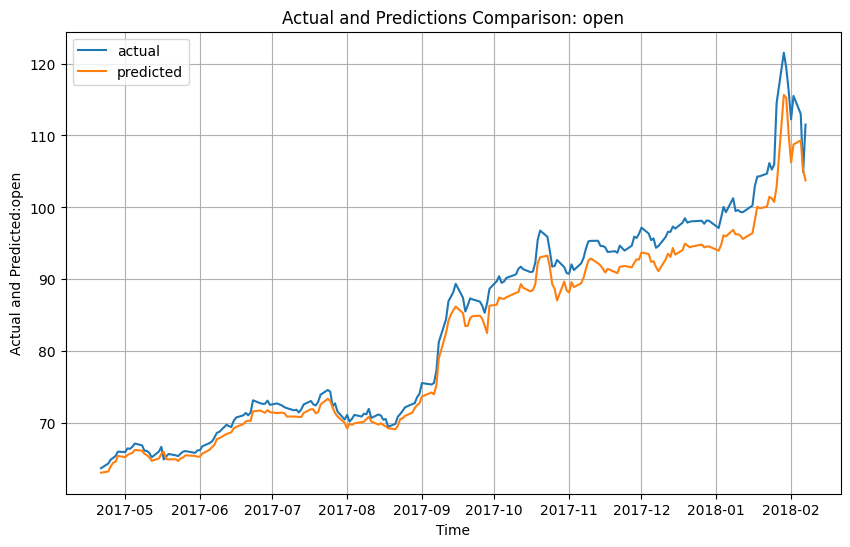




high
Max and Min: 125.86 and 64.29
MSE: 13.422749282276124
RMSE:3.6637070410004298



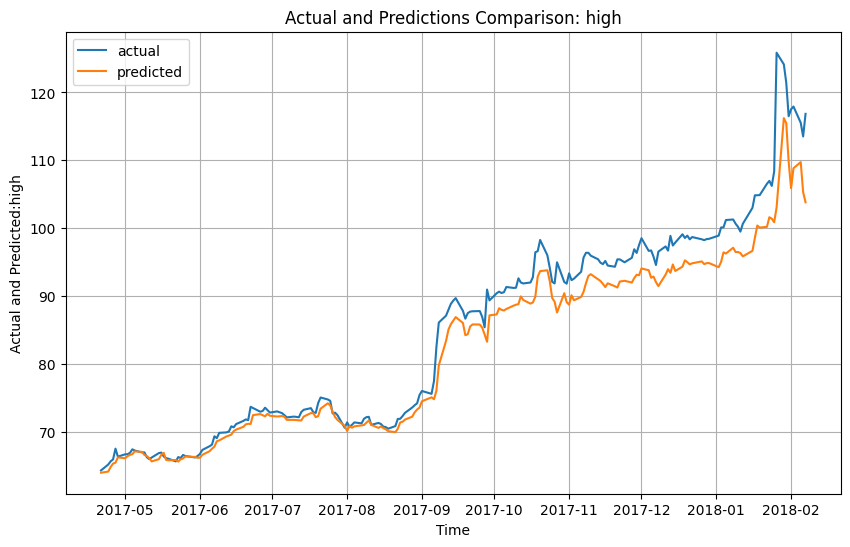




low
Max and Min: 118.98 and 63.547
MSE: 5.356197987821945
RMSE:2.3143461253282633



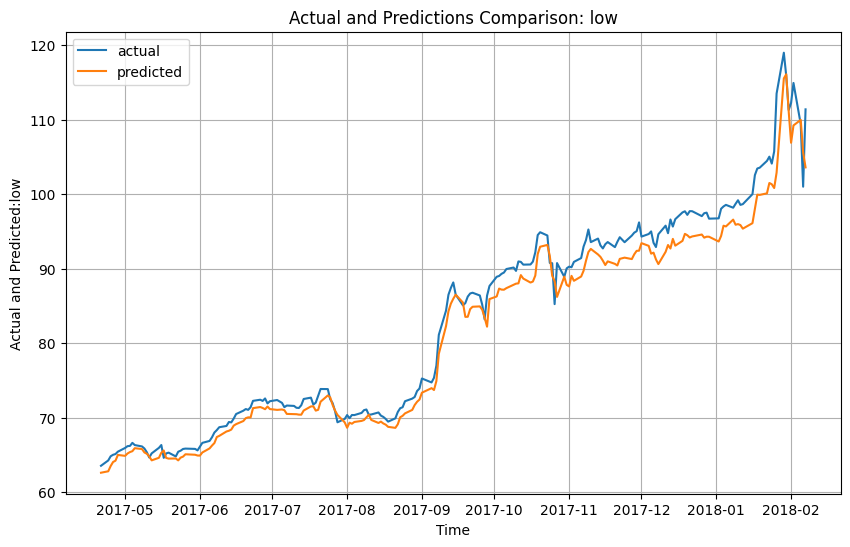




close
Max and Min: 123.21 and 63.82
MSE: 9.947750963875995
RMSE:3.154005542778261



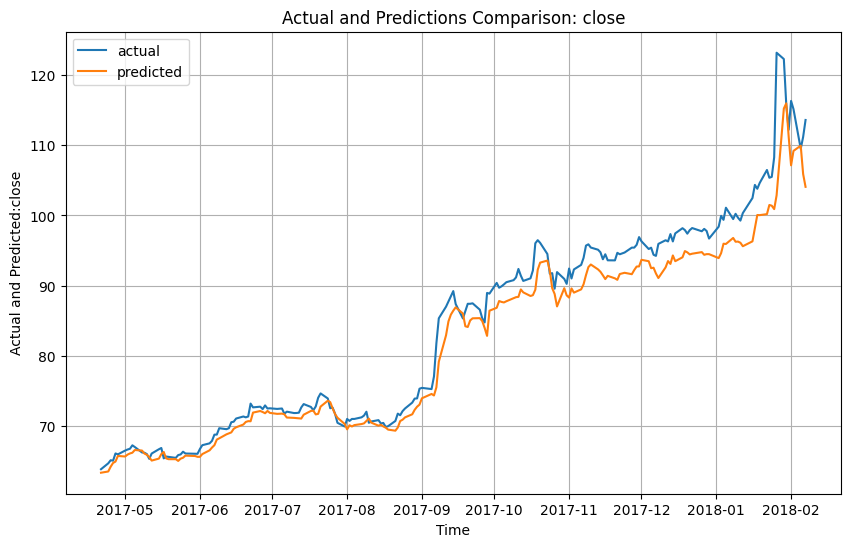

In [ ]:
# make evaluations
evaluations(COLUMNS)